# Introducción

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos.

## Objetivo
Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora.

## Condiciones
La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Tabla de contenidos

1. Introducción
2. Preprocesamiento
3. Entrenamiento y evaluación de modelos
4. Conclusiones

# Preprocesamiento

Importaremos los datos proporcionados en el archivo `/datasets/taxi.csv` para visualizar su contenido, evaluar si tiene datos de valor y que se encuentren en condicones para ser consumidos por los modelos de regresión lineal.

In [1]:
# Importar librearias
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb

In [2]:
# Leyendo archivo CSV
df = pd.read_csv('datasets/taxi.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Como podemos observar, no tenemos ausencia de registros, sin embargo, debemos trabajar con en primera estancia con la columna `datetime` pues cuenta con un formato incorrecto, ademas que debe ser el indice de los datos.

In [3]:
# Imprimiento los primeros 10 registros
df.head(10)

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32
5,2018-03-01 00:50:00,21
6,2018-03-01 01:00:00,7
7,2018-03-01 01:10:00,5
8,2018-03-01 01:20:00,17
9,2018-03-01 01:30:00,12


In [4]:
# Leyendo archivo CSV de la forma correcta
df = pd.read_csv('datasets/taxi.csv',parse_dates=[0],index_col='datetime')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Una vez que tenemos el `df` en la forma correcta, debemos verificar que las fechas del indice se encuentren en orden cronológico pues el trabajar con series de tiempo implica que se hará un análisis y predicción conforme el paso del tiempo.

In [5]:
# Ordenando cronológicamente los registros
df.sort_index(inplace=True)
df.index.is_monotonic

True

`is_monotonic` nos ayuda a confirmar que `df` se encuentra en orden cronológico. De acuerdo con el objetivo, debemos hacer un remuestreo de `df` por hora.

In [6]:
# Muestreo por hora
df = df.resample('1H').sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Como podemos observar, al realizar el remuestreo, este se ejecuta de forma correcta pues prestando atención a la información del `df` antes de este proceso, nos encontramos que los registros se encuentran muestreados cada 10 minutos por lo que al finalizar `resample` nos encontramos con `1/6` de la cantidad de registros anteriormente presentada pasando de `26,496` a `4,416` registros.

Analizaremos el comportamiento de las solicitudes a lo largo del perido de `df` que comprende del `01/Marzo/2018` al `31/Agosto/2018`.

<AxesSubplot:title={'center':'Comportamiento diario'}, xlabel='datetime'>

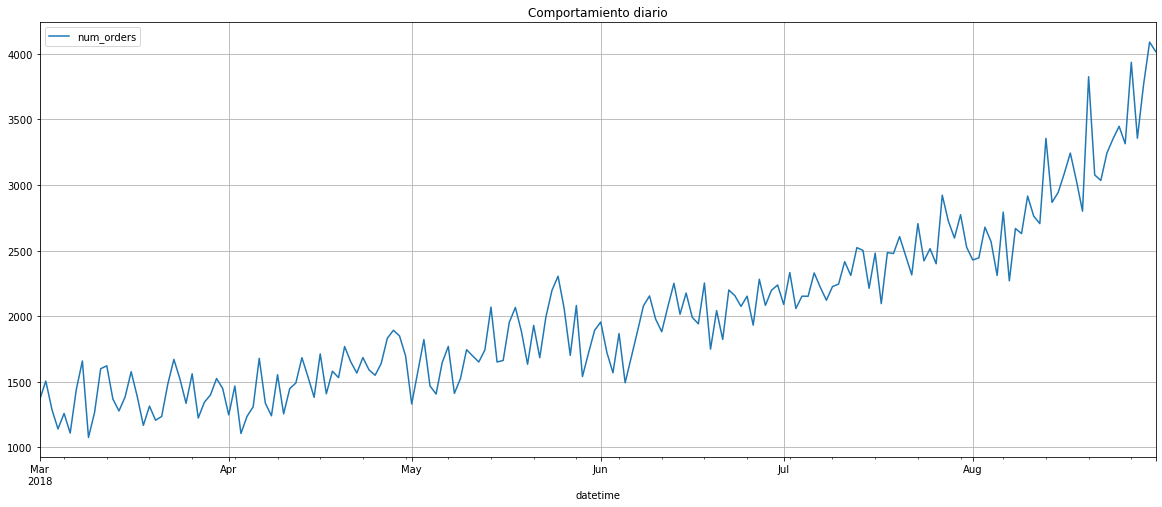

In [7]:
# Visualizando comportamiento por día
data_day = df.resample('1D').sum()
data_day.plot(figsize=(20,8),grid=True,title='Comportamiento diario')

<AxesSubplot:title={'center':'Comportamiento mensual'}, xlabel='datetime'>

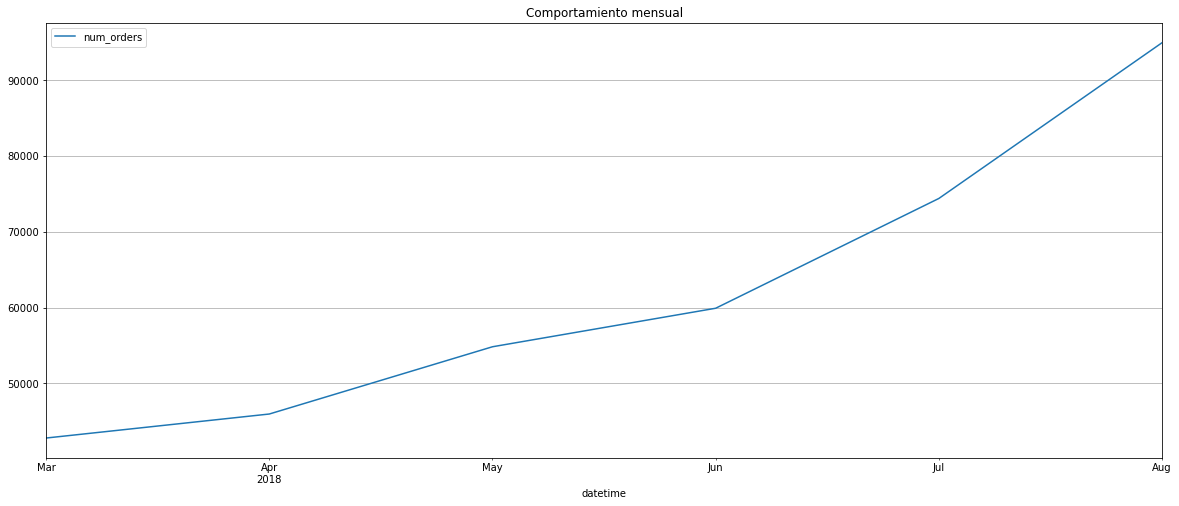

In [8]:
# Visualizando comportamiento por mes
data_month = df.resample('1M').sum()
data_month.plot(figsize=(20,8),grid=True,title='Comportamiento mensual')

<AxesSubplot:title={'center':'Comportamiento por hora'}, xlabel='datetime'>

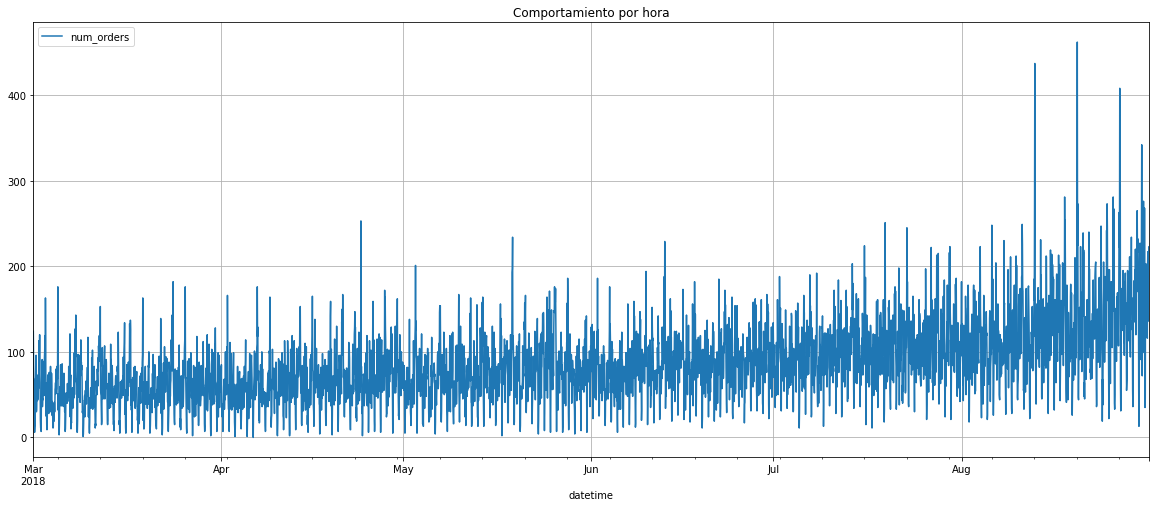

In [9]:
# Visualizando comportamiento por hour
data_hour = df.resample('1H').sum()
data_hour.plot(figsize=(20,8),grid=True,title='Comportamiento por hora')

De este último gráfico no podemos apreciar del todo bien algún patrón más especifico por lo que lo aplicaremos a una ventana de `15 días` para visualizar si en el se encuentra algún patrón reptitivo o es muy aleatorio.

<AxesSubplot:title={'center':'Comportamiento por hora en 15 días'}, xlabel='datetime'>

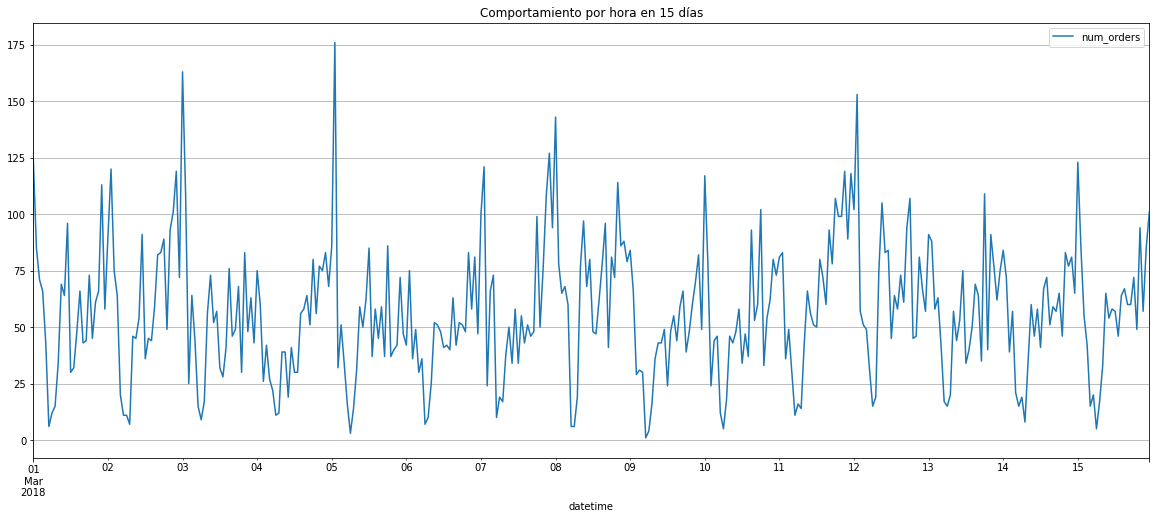

In [10]:
# Visualizando comportamiento por hour
data_hour = df['2018-03-01':'2018-03-15'].resample('1H').sum()
data_hour.plot(figsize=(20,8),grid=True,title='Comportamiento por hora en 15 días')

De los gráficos, podemos concluir lo siguiente:
- Al pasar de los meses, la demanda de taxis, de forma general, va en aumento por lo que aun no teniendo horas picos, la demanda de taxis en el mes de `Marzo` es considerablemente menor a la que se tiene en `Agosto`.
- Al tomar un periodo de tiempo de `15 días`, podemos observar que las horas pico de demanda se encuentran al inicio y al final del día.

Aplicaremos la media movil al `df` completo con la intención de reducir las fluctuaciones que tiene y poder visualizar algún patrón que podría verse oculto entre las fluctuaciones del gráfico anteriormente presentado.

Cabe mencionar que para este punto, comenzaremos a alimentar `df` con información de si mismo.

<AxesSubplot:title={'center':'Comportamiento subizado'}, xlabel='datetime'>

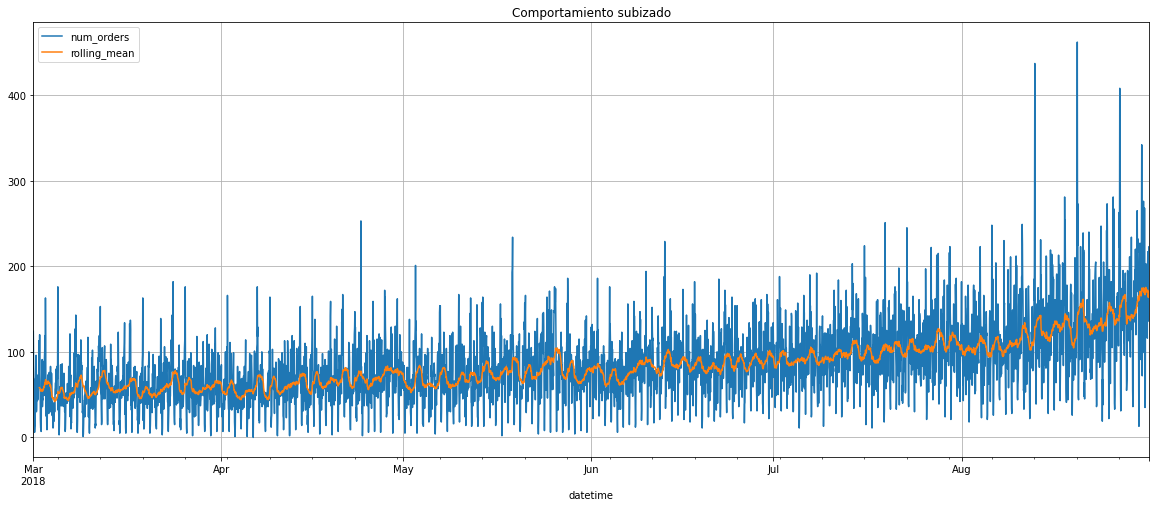

In [11]:
# Aplicando media movil con ventana de 25
df['rolling_mean'] = df.rolling(25).mean()
df.plot(figsize=(20,8),grid=True,title='Comportamiento subizado')

Esta gráfica nos muestra el promedio de demanda diaria de taxis en una ventana de `25` unidades, es decir, se obtiene el promedio de demandas cada `25` muestras y tomamos ese punto como referencia para graficar, por lo que durante los primeros `24` puntos de la gráfica no tenemos información que graficar.

Debido a que no es tan evidente alguna tendencia ajena a la del incremento de demanda, procederemos a hacer uso `seasonal_decompose` que es una librería que nos permite separar los componentes de `tendencia`, `estacionalidad` y `residuo` encontradas en los registros de `df`.

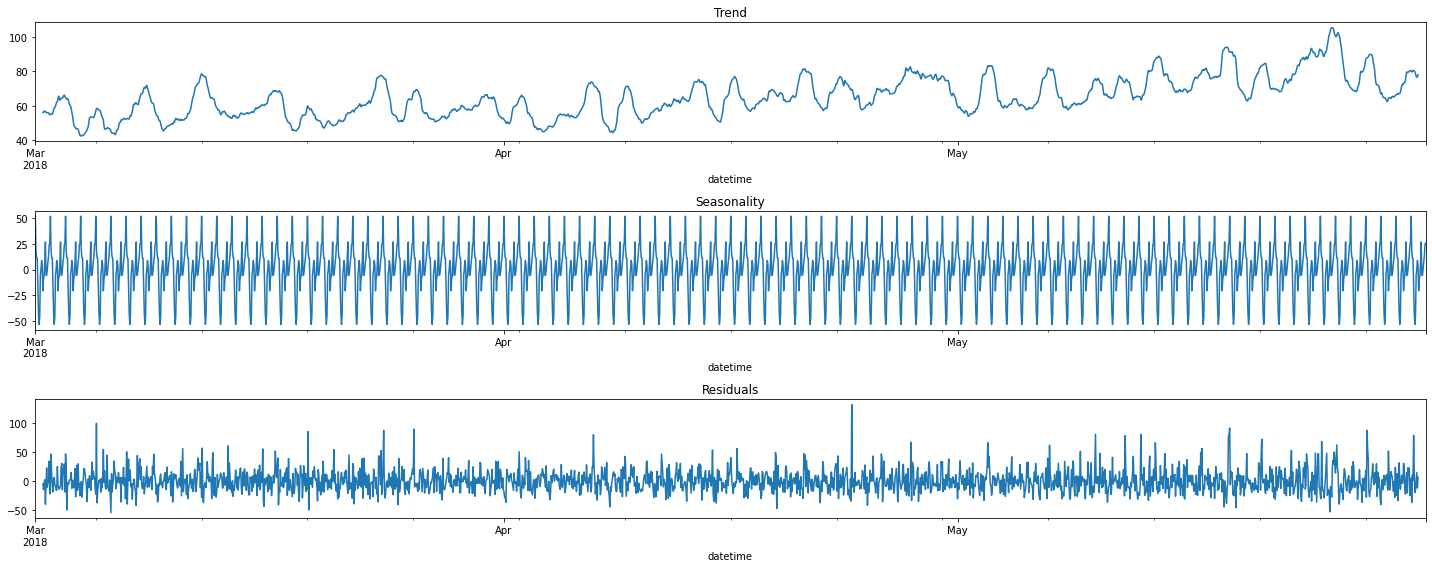

In [12]:
# Encontrando "tendencias", "estacionalidad" y "residuo" de "df"
df = df.drop(columns=['rolling_mean'],axis=1)
decomposed = seasonal_decompose(df['2018-03':'2018-05'])
plt.figure(figsize=(20, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Con estas gráficas confirmarmos que la única tendencia encontrada en los registros de `df` es el aumento de la demanda de taxis, un comportamiento que se repite es la demanda diaria donde al inicio y final del día dicha demanda de solicitudes se ve en aumeno mientas que en ese intervalo la demanda decrece considerablemente y por último el residuo encontrado parece ser simplemente ruido en el proceso pues su aleatoriedad no nos permite visualizar algo en concreto.

Con la intención de obtener información para poder hacer el entrenamiento de los modelos de regresión, es importante que se utilice la técnica de creación de características, lo cual es muy sencilla pues implementaremos lo ya anteriormente realizado con el fin de alimentar a `df` con información a partir de la serie temporal.

In [13]:
# Creación de características usando la función "make_features"
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(df, 5, 5)
df.head()

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,rolling_mean
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN


Una vez teniendo alimentado a `df` con información, procederemos a hacer el entrenamiento y evaluación de diversos algoritmos de regresión lineal.

# Entrenamiento y evaluación de modelos de regresión lineal

Comenzaremos con el modelo de `regresión lineal múltiple`.

## Regresión lineal múltiple

In [14]:
# Modelo de regresión lineal
train, test = train_test_split(df,shuffle=False,test_size=0.2)
train = train.dropna()

X_train = train.drop(columns=['num_orders'],axis=1)
X_test = test.drop(columns=['num_orders'],axis=1)
y_train = train['num_orders']
y_test = test ['num_orders']

model = LinearRegression()
model.fit(X_train,y_train)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(y_train,train_predict,squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(y_test,test_predict,squared=False))

RECM para el conjunto de entrenamiento: 29.083765382887904
RECM para el conjunto de prueba: 47.42322988587504


## Árboles de decisión

In [15]:
# Encontrando los mejores hiper parámetros
dtr = DecisionTreeRegressor(random_state=12345)
parameters = {'max_depth': range(2, 15), 
              'min_samples_split': range(2,20,2), 
              'min_samples_leaf': range(2,20,2),
              'criterion': ['squared_error', 'friedman_mse','poisson'],
              'max_features': ['auto','sqrt','log2']}
tscv = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(dtr, parameters,cv=tscv,n_jobs=-1,scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'squared_error', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 10, 'min_samples_split': 2}
Best score:  -31.447305919431223
Best estimator:  DecisionTreeRegressor(max_depth=3, max_features='auto', min_samples_leaf=10,
                      random_state=12345)


In [16]:
# Modelo de regresión lineal
model = DecisionTreeRegressor(random_state=12345, criterion='squared_error',max_depth=3,max_features='auto',min_samples_leaf=10,min_samples_split=2)
model.fit(X_train,y_train)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(y_train,train_predict,squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(y_test,test_predict,squared=False))

RECM para el conjunto de entrenamiento: 29.387797205841874
RECM para el conjunto de prueba: 58.85174600695515


## Bosques aleatorios

In [19]:
# Encontrando los mejores hiper parámetros
rfr = RandomForestRegressor(random_state=12345)
parameters = {'n_estimators': range(1,162,25),
              'max_depth': range(2,15),
              'min_samples_split': range(2,20,2),
              'min_samples_leaf': range(2,20,2),
              'criterion': ['squared_error','friedman_mse','poisson']}
tscv = TimeSeriesSplit(n_splits=3)
grid = GridSearchCV(rfr, parameters,cv=tscv,n_jobs=-1,scoring='neg_root_mean_squared_error')
grid.fit(X_train, y_train)
print("Best parameters: ", grid.best_params_)
print("Best score: ", grid.best_score_)
print("Best estimator: ", grid.best_estimator_)

Best parameters:  {'criterion': 'squared_error', 'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 12, 'n_estimators': 26}
Best score:  -30.83256530175771
Best estimator:  RandomForestRegressor(max_depth=9, min_samples_leaf=2, min_samples_split=12,
                      n_estimators=26, random_state=12345)


In [20]:
# Modelo de regresión lineal
model = RandomForestRegressor(random_state=12345, criterion='squared_error',max_depth=9,min_samples_leaf=2,min_samples_split=12,n_estimators=26)
model.fit(X_train,y_train)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(y_train,train_predict,squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(y_test,test_predict,squared=False))

RECM para el conjunto de entrenamiento: 22.374602363631972
RECM para el conjunto de prueba: 54.764160899124846


Por último, implementaremos un algoritmo con potenciación de gradiente para verificar si hay un mejor rendimiento en las predicciones realizadas.

## LightGBM

In [21]:
# Modelo de regresión lineal con potenciación de gradiente
train_data = lgb.Dataset(X_train,label=y_train)
test_data = lgb.Dataset(X_test,label=y_test)

params = {'boosting_type': 'gbdt',
          'objective': 'regression',
          'metric': 'rmse',
          'num_leaves': 31,
          'learning_rate': 0.05}

model = lgb.train(params, train_data, num_boost_round=1000, valid_sets=[test_data])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

print("RECM para el conjunto de entrenamiento:", mean_squared_error(y_train,train_predict,squared=False))
print("RECM para el conjunto de prueba:", mean_squared_error(y_test,test_predict,squared=False))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1180
[LightGBM] [Info] Number of data points in the train set: 3527, number of used features: 9
[LightGBM] [Info] Start training from score 74.302523
[1]	valid_0's rmse: 73.4046
[2]	valid_0's rmse: 72.4641
[3]	valid_0's rmse: 71.5412
[4]	valid_0's rmse: 70.7513
[5]	valid_0's rmse: 70.0642
[6]	valid_0's rmse: 69.2898
[7]	valid_0's rmse: 68.5803
[8]	valid_0's rmse: 67.9013
[9]	valid_0's rmse: 67.3629
[10]	valid_0's rmse: 66.7758
[11]	valid_0's rmse: 66.1616
[12]	valid_0's rmse: 65.6789
[13]	valid_0's rmse: 65.2559
[14]	valid_0's rmse: 64.8253
[15]	valid_0's rmse: 64.1991
[16]	valid_0's rmse: 63.7297
[17]	valid_0's rmse: 63.3826
[18]	valid_0's rmse: 62.9777
[19]	valid_0's rmse: 62.4558
[20]	valid_0's rmse: 61.9104
[21]	valid_0's rmse: 61.6222
[22]	valid_0's rmse: 61.1667
[23]	valid_0's rmse: 60.773

[476]	valid_0's rmse: 53.8957
[477]	valid_0's rmse: 53.8862
[478]	valid_0's rmse: 53.8877
[479]	valid_0's rmse: 53.8862
[480]	valid_0's rmse: 53.8806
[481]	valid_0's rmse: 53.8981
[482]	valid_0's rmse: 53.9169
[483]	valid_0's rmse: 53.9122
[484]	valid_0's rmse: 53.9102
[485]	valid_0's rmse: 53.9207
[486]	valid_0's rmse: 53.9209
[487]	valid_0's rmse: 53.908
[488]	valid_0's rmse: 53.91
[489]	valid_0's rmse: 53.9116
[490]	valid_0's rmse: 53.9099
[491]	valid_0's rmse: 53.9072
[492]	valid_0's rmse: 53.907
[493]	valid_0's rmse: 53.9135
[494]	valid_0's rmse: 53.9114
[495]	valid_0's rmse: 53.9118
[496]	valid_0's rmse: 53.9099
[497]	valid_0's rmse: 53.9108
[498]	valid_0's rmse: 53.9187
[499]	valid_0's rmse: 53.9167
[500]	valid_0's rmse: 53.9049
[501]	valid_0's rmse: 53.9028
[502]	valid_0's rmse: 53.9072
[503]	valid_0's rmse: 53.9069
[504]	valid_0's rmse: 53.9048
[505]	valid_0's rmse: 53.9024
[506]	valid_0's rmse: 53.9059
[507]	valid_0's rmse: 53.9129
[508]	valid_0's rmse: 53.9149
[509]	valid_0'

[755]	valid_0's rmse: 54.2854
[756]	valid_0's rmse: 54.2817
[757]	valid_0's rmse: 54.278
[758]	valid_0's rmse: 54.2776
[759]	valid_0's rmse: 54.2792
[760]	valid_0's rmse: 54.2853
[761]	valid_0's rmse: 54.2874
[762]	valid_0's rmse: 54.2865
[763]	valid_0's rmse: 54.2871
[764]	valid_0's rmse: 54.2857
[765]	valid_0's rmse: 54.2882
[766]	valid_0's rmse: 54.2869
[767]	valid_0's rmse: 54.2878
[768]	valid_0's rmse: 54.2872
[769]	valid_0's rmse: 54.286
[770]	valid_0's rmse: 54.2861
[771]	valid_0's rmse: 54.2873
[772]	valid_0's rmse: 54.2889
[773]	valid_0's rmse: 54.2912
[774]	valid_0's rmse: 54.2972
[775]	valid_0's rmse: 54.2991
[776]	valid_0's rmse: 54.3008
[777]	valid_0's rmse: 54.3017
[778]	valid_0's rmse: 54.3086
[779]	valid_0's rmse: 54.2994
[780]	valid_0's rmse: 54.2966
[781]	valid_0's rmse: 54.2977
[782]	valid_0's rmse: 54.2975
[783]	valid_0's rmse: 54.2996
[784]	valid_0's rmse: 54.291
[785]	valid_0's rmse: 54.2886
[786]	valid_0's rmse: 54.2811
[787]	valid_0's rmse: 54.2803
[788]	valid_0

De acuerdo a los resultados, podemos observar que aunque tenemos algoritmos con procesos un poco más complejos que la `regresión lineal múltiple`, estos tienen un desempeño un poco menos eficiente y esto puede deberse a que la construcción de características de `df` surgen a partir de los datos iniciales, es decir, tienen dependencia uno de otro ya sea a partir del `indice` o de la columna `objetivo`.

# Conclusión

De acuerdo con el resultado, podemos tener una predicción eficiente haciendo uso de algoritmo de `regresión lineal múltimple` esto se debe a que las columnas utilizadas como caracteristicas son resultado de un proceso sobre las inicialmente existentes por lo que dichas caracteristicas describen de forma más completa la serie temporal encontrada en `df`. Por otro lado, podemos observar una tendencia en aumento en la demanda conforme pasan los meses, esto habla que el requerimiento de taxis aparentemente al final del año debe ser mayor que en el mes de Agosto que es a su vez mayor que el mes de Marzo, sin embargo, esto no es un hecho pues para poder describir de forma correcta dicha tendencia, lo ideal sería tener datos del año completo para poder describir dicha tendencia. Por último, podemos detectar de igual forma que la demanda es más alta al inicio y final del día, esto puede deberse a que la mayor cantidad de vuelos entrantes y salientes son más frecuentes en estos horarios que el resto.